### Imports

In [59]:
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from dotenv import load_dotenv

### Getting data from API and making DataFrames

In [60]:
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [61]:
DATE_BEGIN = '2023-03-01'
DATE_END = '2023-09-01'

r_visits = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r_regs = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

df_visits = r_visits.json()
df_regs = r_regs.json()

df_visits = pd.DataFrame(df_visits)
df_regs = pd.DataFrame(df_regs)

### Calculating metrics

In [62]:
mask = ~df_visits['user_agent'].str.contains('bot')
df_visits = df_visits[mask]
df_visits['datetime'] = pd.to_datetime(df_visits['datetime']).dt.date
df_visits.sort_values('datetime', ascending=False, inplace=True)
df_visits.drop_duplicates('visit_id', inplace=True)
grouped_df_visits = df_visits.groupby(['datetime', 'platform']).agg({'visit_id': 'count'})
grouped_df_visits.reset_index(inplace=True)
grouped_df_visits.rename(columns={'datetime': 'date_group', 'visit_id': 'visits'}, inplace=True)

df_regs['datetime'] = pd.to_datetime(df_regs['datetime']).dt.date
grouped_df_regs = df_regs.groupby(['datetime', 'platform']).agg({'user_id': 'count'})
grouped_df_regs.reset_index(inplace=True)
grouped_df_regs.rename(columns={'datetime': 'date_group', 'user_id': 'registrations'}, inplace=True)

merged_df = pd.merge(grouped_df_visits, grouped_df_regs, left_on=['date_group', 'platform'], right_on=['date_group', 'platform'])
merged_df['conversion'] = merged_df['registrations'] / merged_df['visits'] * 100
merged_df.to_json('./conversion.json')

### Adding ads

In [63]:
df_ads = pd.read_csv('ads.csv')
mask = (df_ads['date'] >= DATE_BEGIN) & (df_ads['date'] <= DATE_END)
df_ads = df_ads[mask]
df_ads['date'] = pd.to_datetime(df_ads['date']).dt.date
grouped_df_ads = df_ads.groupby(['date', 'utm_campaign']).agg({'cost': 'sum'})
grouped_df_ads.reset_index(inplace=True)
grouped_df_ads.rename(columns={'date': 'date_group'}, inplace=True)

conv_ads_df = merged_df.groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
conv_ads_df.reset_index(inplace=True)
conv_ads_df = pd.merge(conv_ads_df, grouped_df_ads, left_on='date_group', right_on='date_group', how='left')
conv_ads_df.fillna({'utm_campaign': 'none'}, inplace=True)
conv_ads_df.fillna({'cost': 0}, inplace=True)
conv_ads_df['cost'] = conv_ads_df['cost'].astype(int)

columns = ['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']
conv_ads_df = conv_ads_df[columns]
conv_ads_df.to_json('ads.json')

### Visualization

##### Total visits

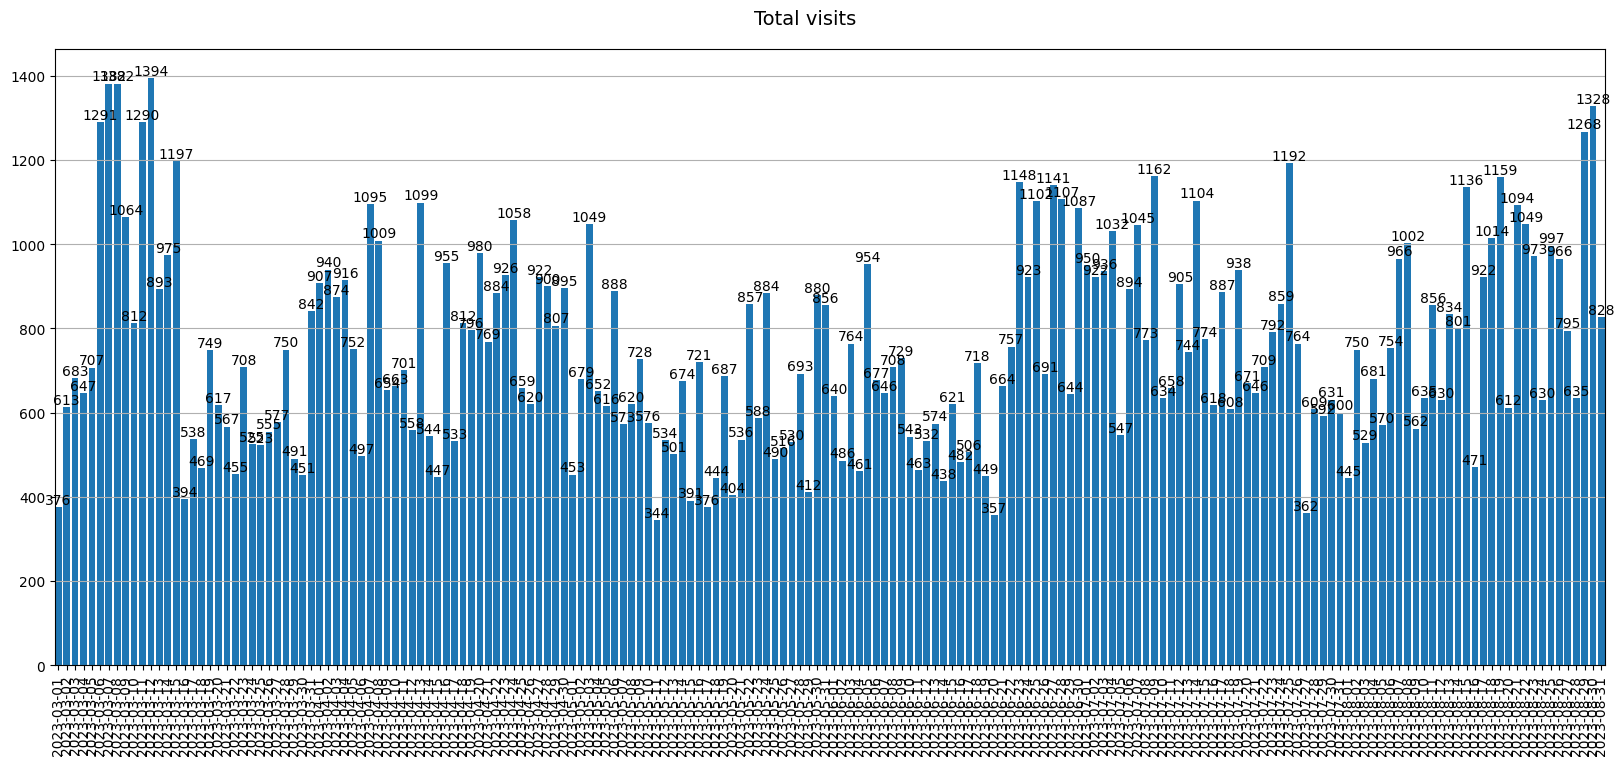

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
fig.suptitle('Total visits', y=0.93, fontsize=14)
visits = ax.bar(conv_ads_df['date_group'], conv_ads_df['visits'])
ax.set_xticks(conv_ads_df['date_group'])

for bar in visits:
    y = bar.get_height()
    ax.annotate(f"{y}", xy=(bar.get_x() + bar.get_width() / 2, y), xytext=(0, 0), textcoords="offset points", ha='center', va='bottom')

ax.set_xticklabels(conv_ads_df['date_group'], rotation=90)
ax.margins(x=0)
ax.grid(axis='y')
plt.savefig('charts/chart1.png', format='png')
plt.show()

##### Total visits per platform

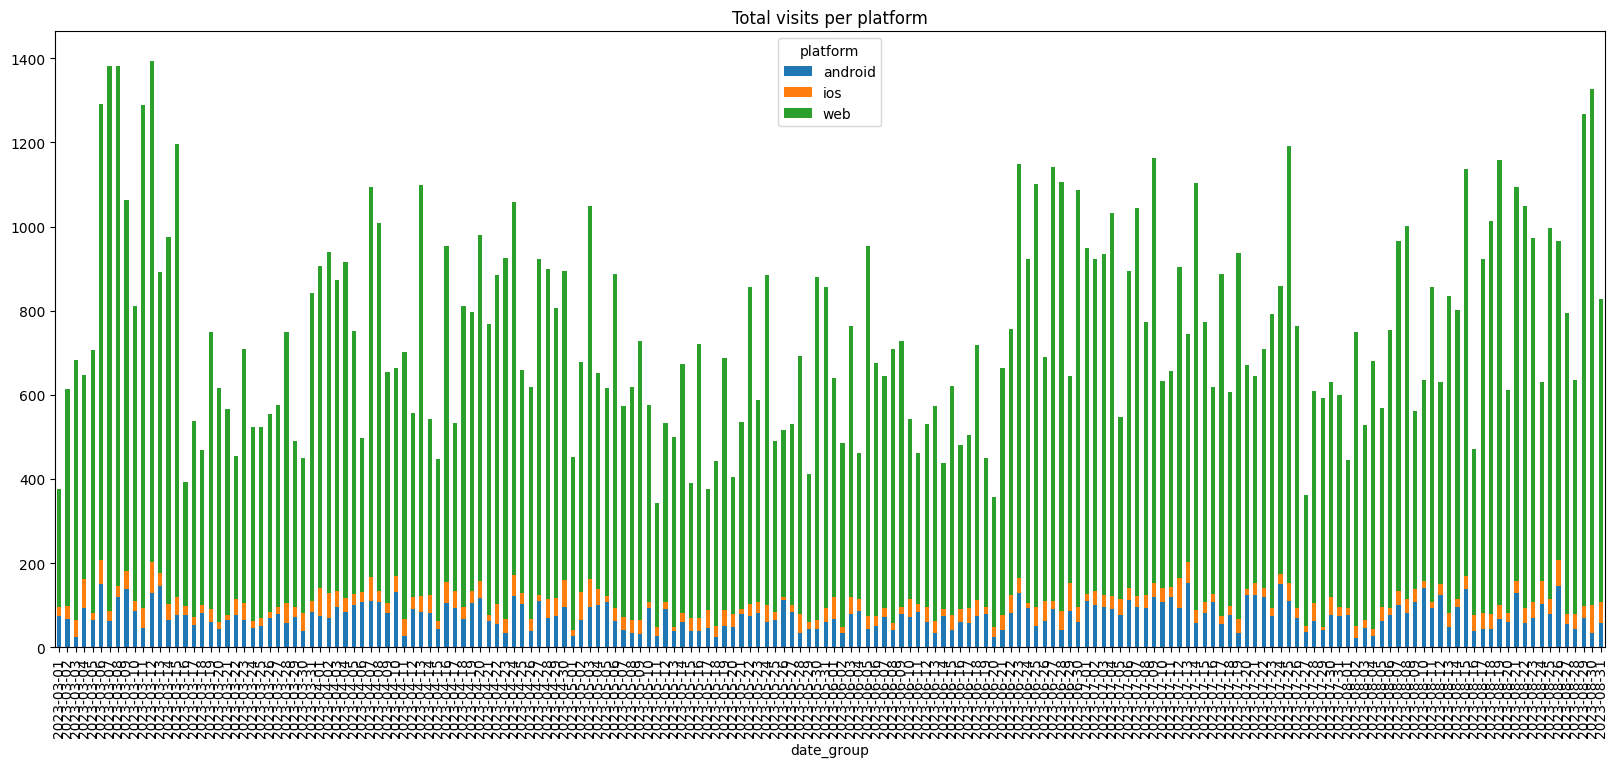

In [65]:
bar = pd.pivot_table(merged_df, index='date_group', values='visits', columns='platform')
bar.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Total visits per platform')
plt.savefig('charts/chart2.png', format='png')
plt.show()

##### Total registrations

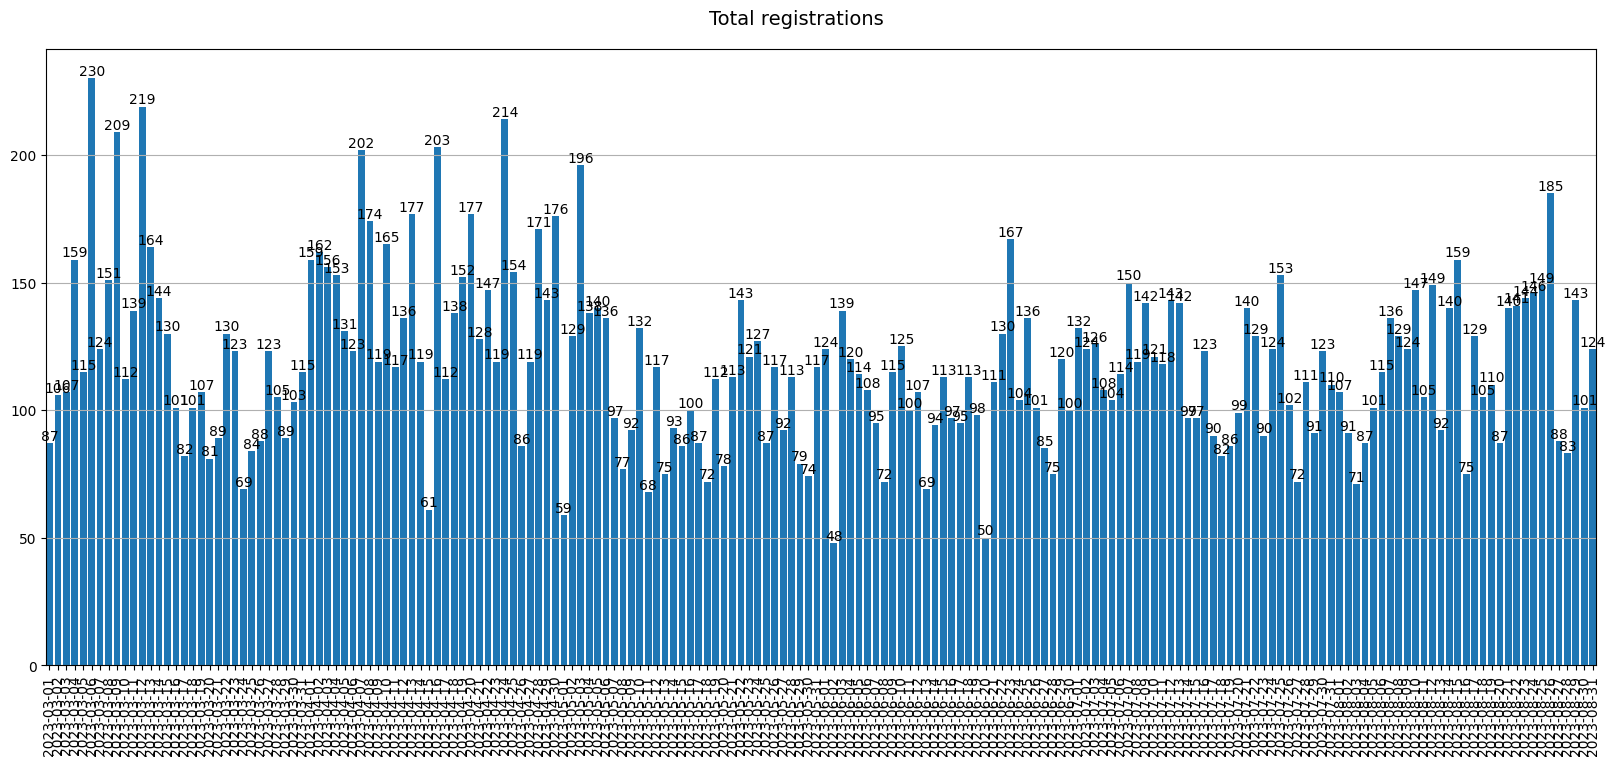

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
fig.suptitle('Total registrations', y=0.93, fontsize=14)
registrations = ax.bar(conv_ads_df['date_group'], conv_ads_df['registrations'])
ax.set_xticks(conv_ads_df['date_group'])

for bar in registrations:
    y = bar.get_height()
    ax.annotate(f"{y}", xy=(bar.get_x() + bar.get_width() / 2, y), xytext=(0, 0), textcoords="offset points", ha='center', va='bottom')

ax.set_xticklabels(conv_ads_df['date_group'], rotation=90)
ax.margins(x=0)
ax.grid(axis='y')
plt.savefig('charts/chart3.png', format='png')
plt.show()

##### Total registrations per platform

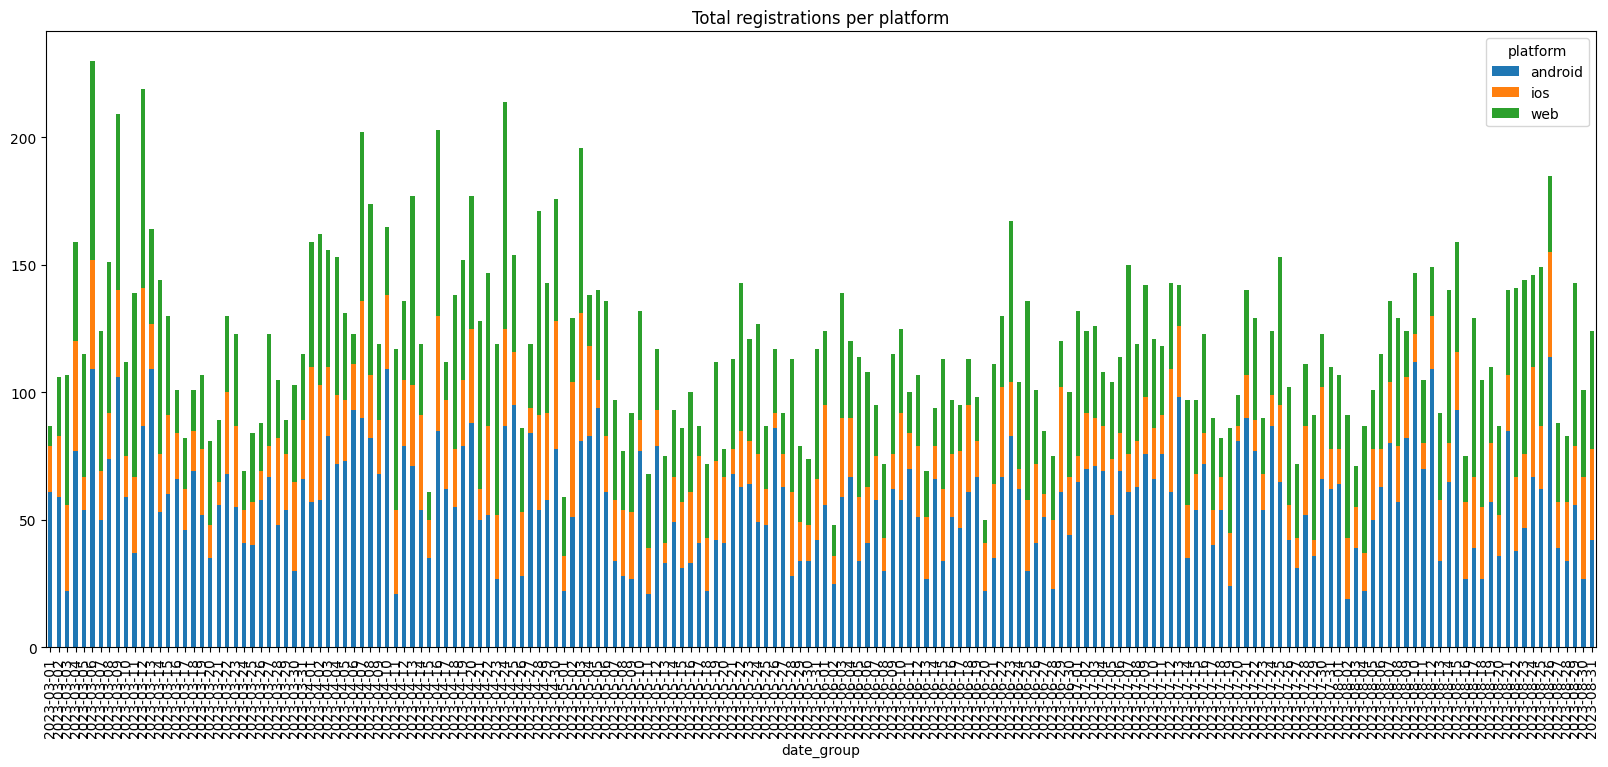

In [67]:
bar = pd.pivot_table(merged_df, index='date_group', values='registrations', columns='platform')
bar.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Total registrations per platform')
plt.savefig('charts/chart4.png', format='png')
plt.show()

##### Conversion per platform

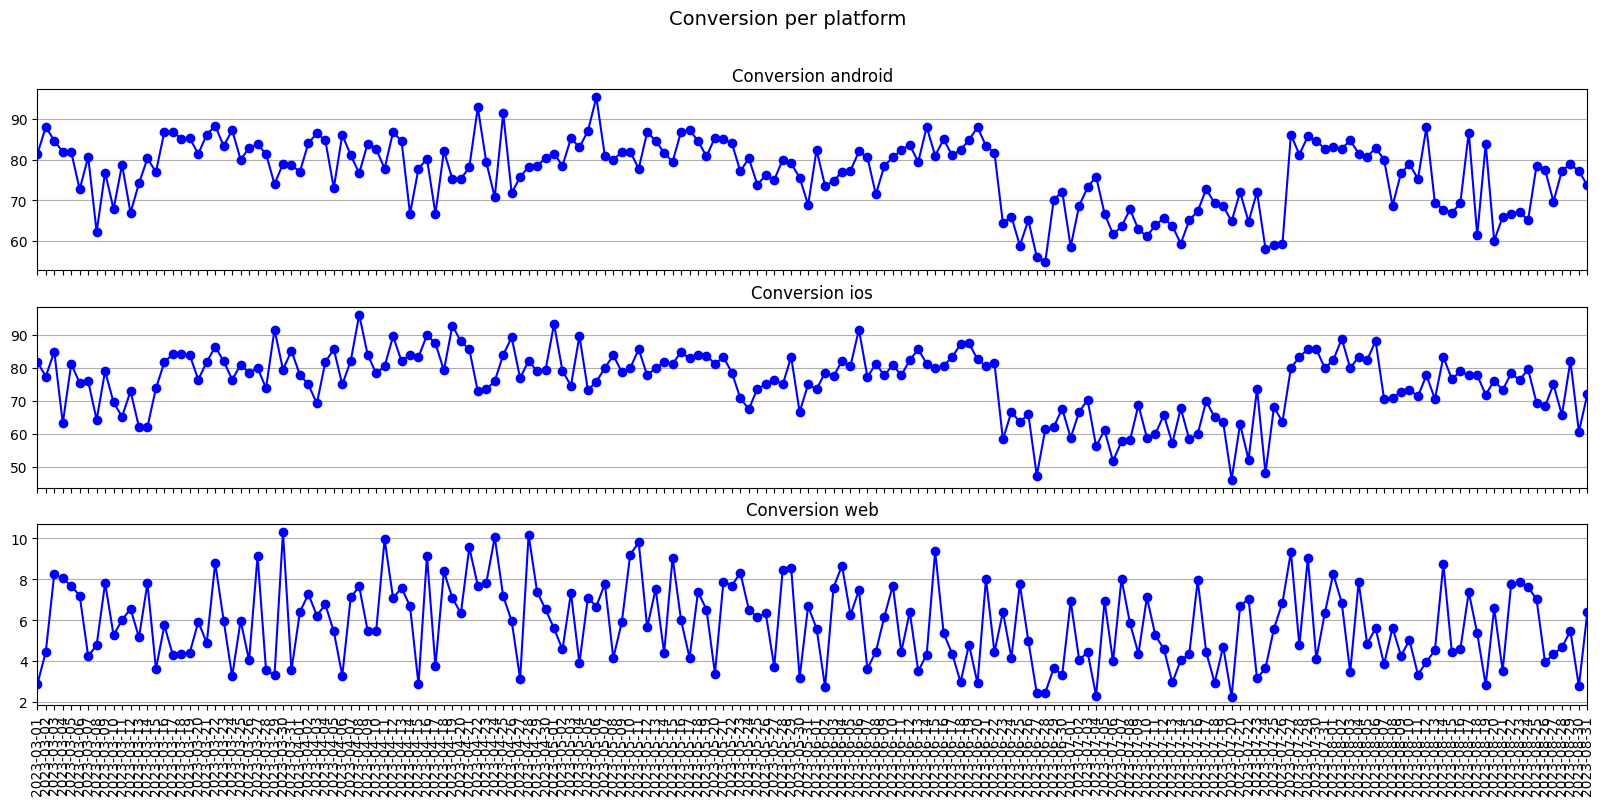

In [68]:
fig, ax = plt.subplots(3, sharex=True)
fig.set_size_inches(20, 8)
fig.suptitle('Conversion per platform', fontsize=14)

indices = merged_df['date_group'].unique()

for x, platform in enumerate(['android', 'ios', 'web']):
    df_filtered = merged_df[merged_df['platform'] == platform]
    ax[x].plot(indices, df_filtered['conversion'], 'bo', linestyle='solid')
    ax[x].margins(x=0)
    ax[x].set_title(f'Conversion {platform}')
    ax[x].set_xticks(conv_ads_df['date_group'])
    ax[x].set_xticklabels(indices, rotation=90)
    ax[x].grid(axis='y')
plt.savefig('charts/chart5.png', format='png')
plt.show()


##### Total conversion

/tmp/ipykernel_1168/1854635382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['conversion'] = round(df_filtered['registrations'] / df_filtered['visits'] * 100, 2)


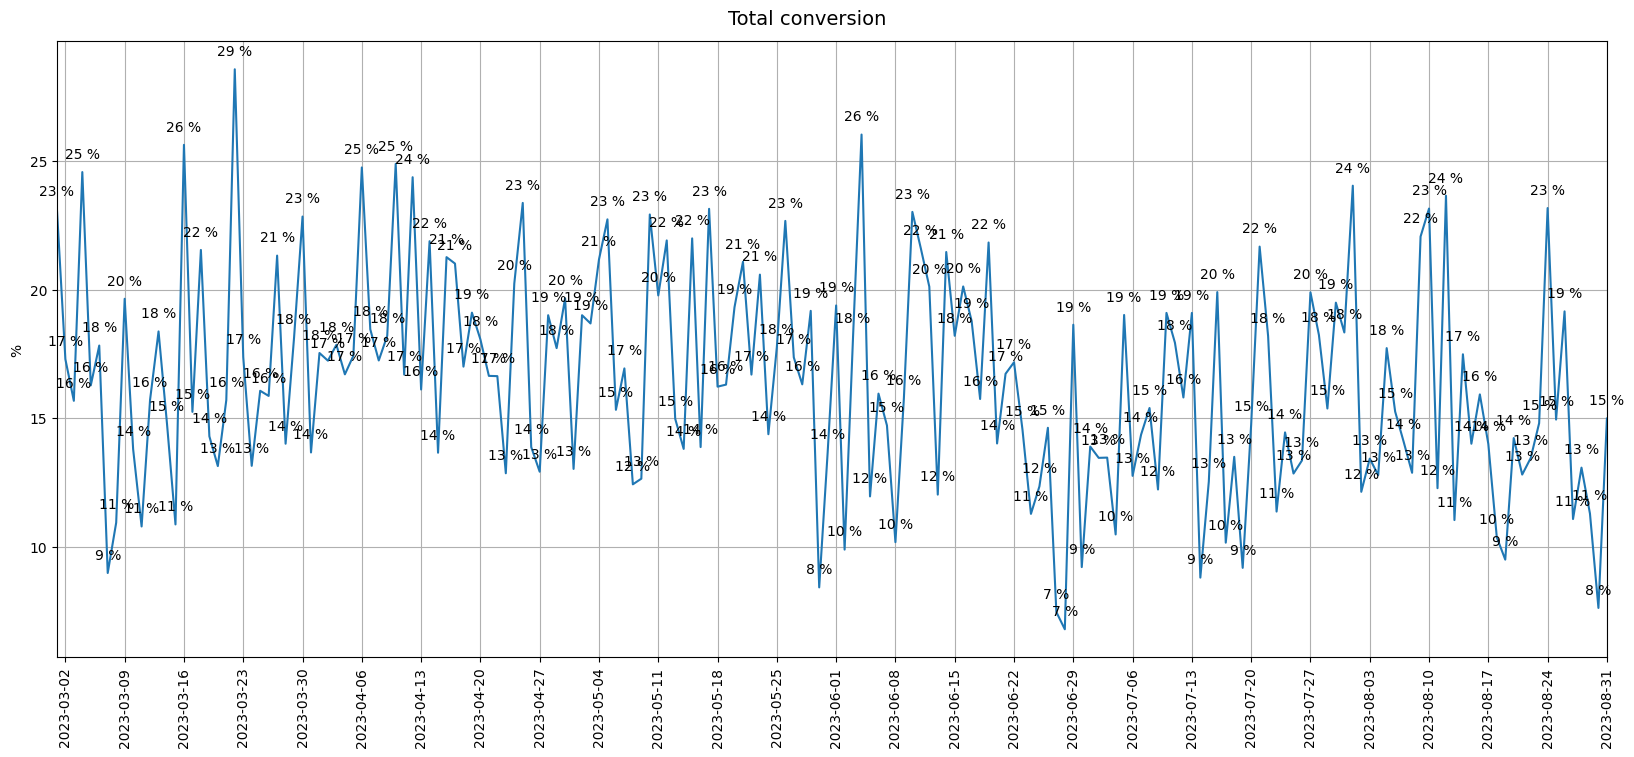

In [69]:
df_filtered = conv_ads_df[['date_group', 'visits', 'registrations']]
df_filtered['conversion'] = round(df_filtered['registrations'] / df_filtered['visits'] * 100, 2)

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
fig.suptitle('Total conversion', fontsize=14, y=0.92)

ax.plot('date_group', 'conversion', data=df_filtered)
ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_tick_params(which='major', rotation=90)
ax.yaxis.set_label_text('%')
for i, txt in enumerate(df_filtered['conversion']):
    ax.annotate(f'{txt:.0f} %', (df_filtered['date_group'][i], txt), textcoords="offset points", xytext=(0,10), ha='center')
ax.grid()
plt.margins(x=0)
plt.savefig('charts/chart6.png', format='png')
plt.show()

##### Ad Campaign cost

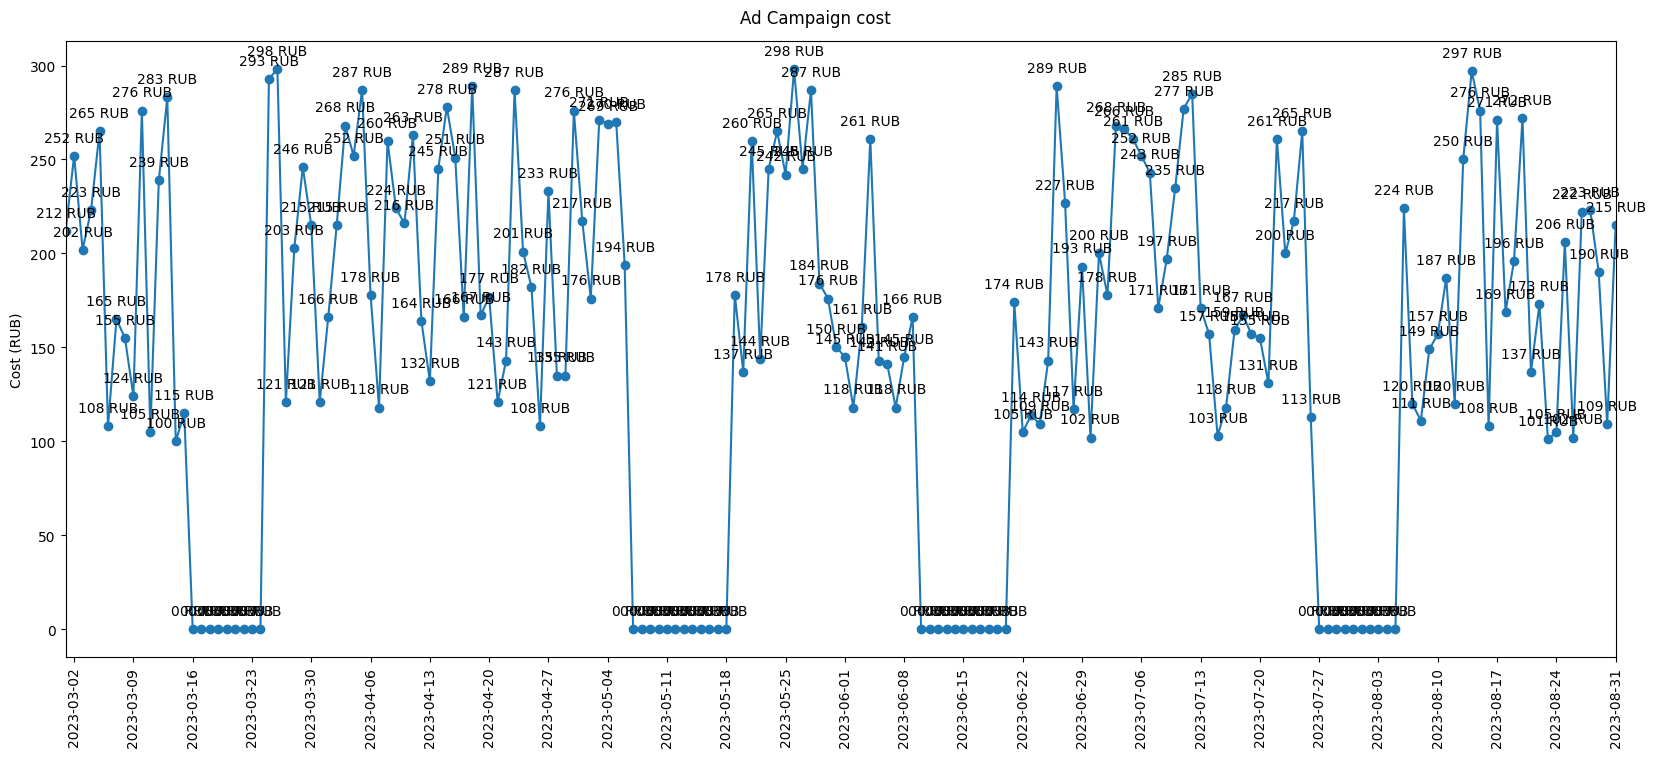

In [70]:
df_filtered = conv_ads_df[['date_group', 'cost']]

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
fig.suptitle('Ad Campaign cost', y=0.92)
ax.plot('date_group', 'cost', data=df_filtered, marker='o')
ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_tick_params(which='major', rotation=90)
ax.yaxis.set_label_text('Cost (RUB)')
for i, txt in enumerate(df_filtered['cost']):
    ax.annotate(f'{txt:.0f} RUB', (df_filtered['date_group'][i], txt), textcoords="offset points", xytext=(0,10), ha='center')

plt.margins(x=0)
plt.savefig('charts/chart7.png', format='png')
plt.show()

##### Visits and registrations per ad campaign

/tmp/ipykernel_1168/1804997779.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


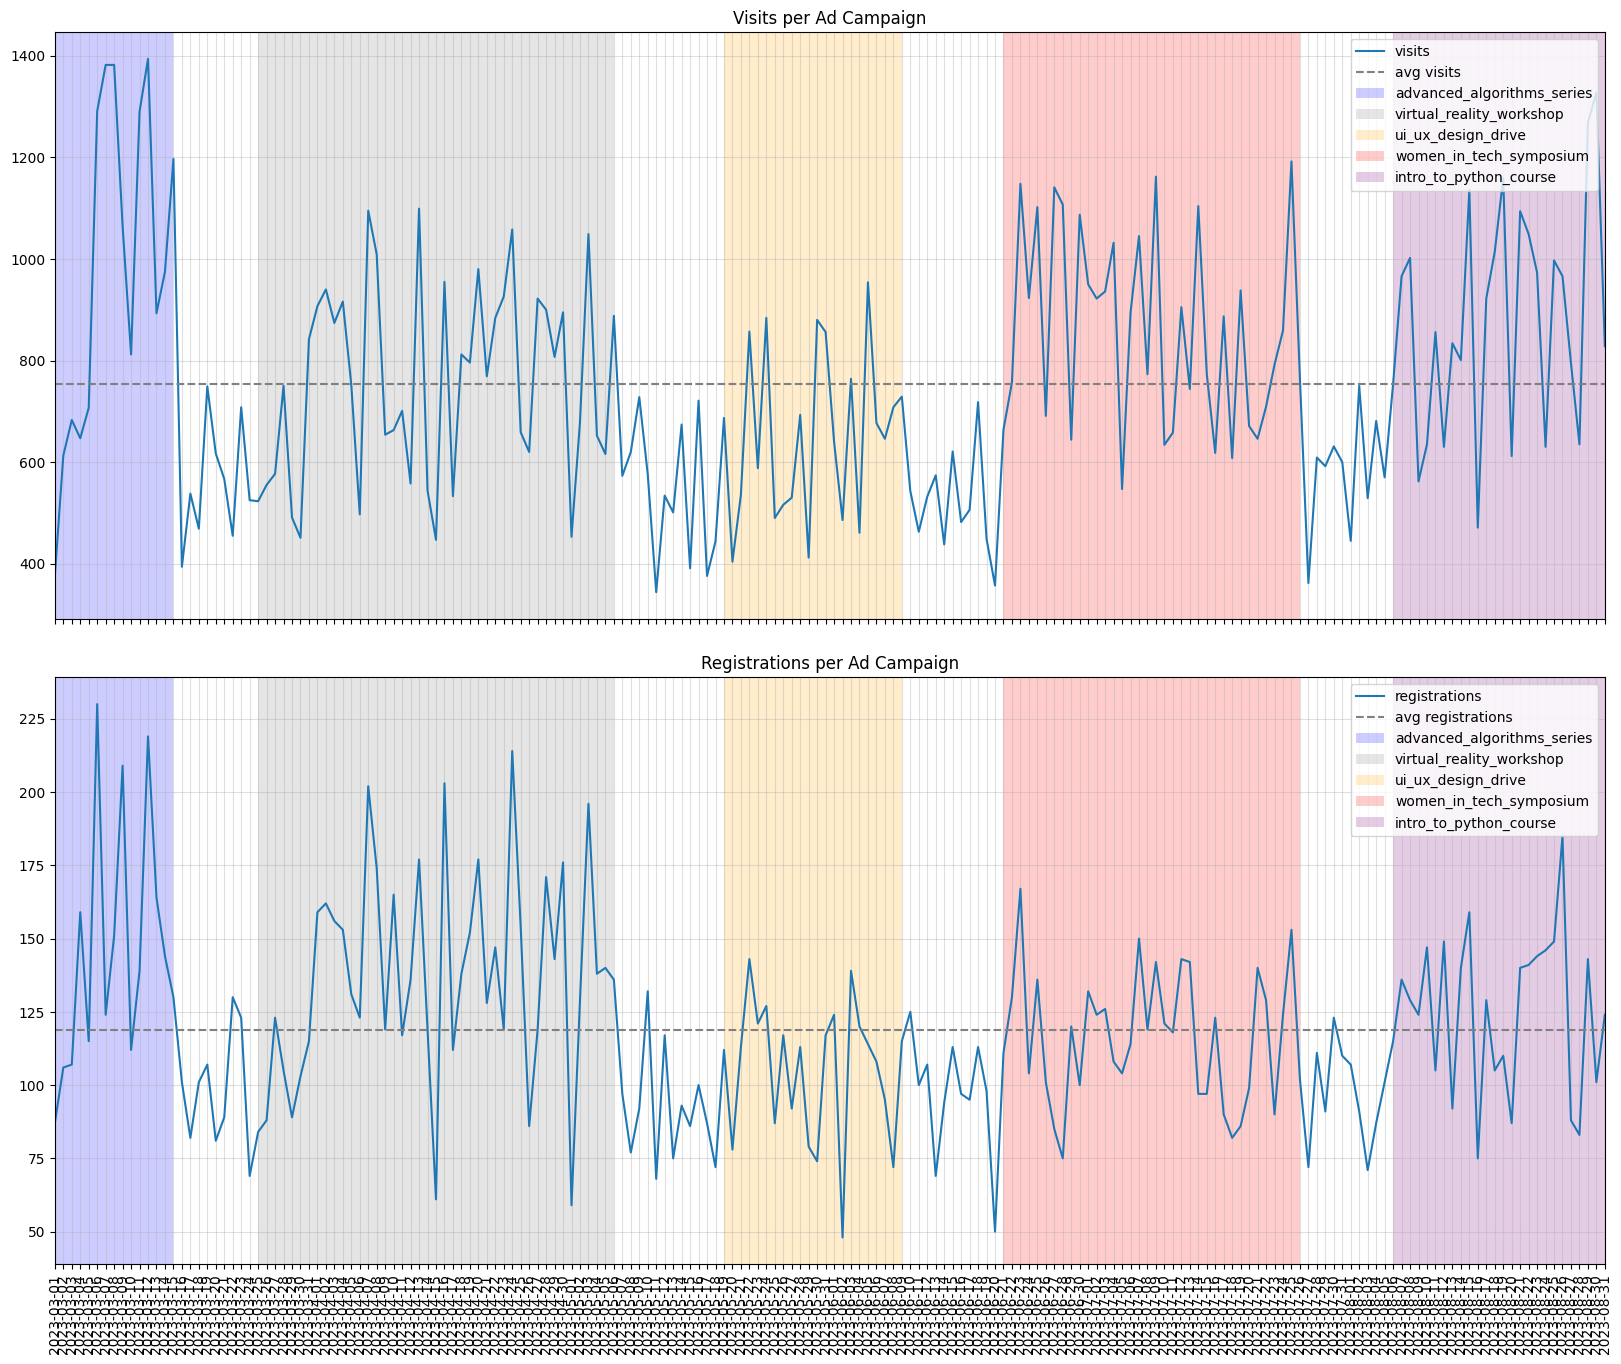

In [71]:
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(20, 16)
fig.subplots_adjust(hspace=0.1)

colors = ['blue', 'green', 'grey', 'orange', 'red', 'purple']

conv_ads_df['mean_visits'] = conv_ads_df['visits'].mean()
conv_ads_df['mean_registrations'] = conv_ads_df['registrations'].mean()

ax[0].title.set_text('Visits per Ad Campaign')
ax[0].plot(conv_ads_df['date_group'], conv_ads_df['visits'], label='visits')
ax[0].plot(conv_ads_df['date_group'], conv_ads_df['mean_visits'], label='avg visits', linestyle='dashed', color='grey')
for i, campaign in enumerate(conv_ads_df['utm_campaign'].unique()):
    if campaign != 'none':
        xs = conv_ads_df[conv_ads_df['utm_campaign'] == campaign]['date_group']
        xs.reset_index(drop=True, inplace=True)
        ax[0].axvspan(xs[0], xs[len(xs) - 1], alpha=0.2, facecolor=colors[i], label=campaign)
ax[0].legend(loc='upper right')
ax[0].grid(alpha=0.4)
ax[0].margins(x=0)

ax[1].title.set_text('Registrations per Ad Campaign')
ax[1].plot(conv_ads_df['date_group'], conv_ads_df['registrations'], label='registrations')
ax[1].plot(conv_ads_df['date_group'], conv_ads_df['mean_registrations'], label='avg registrations', linestyle='dashed', color='grey')
for i, campaign in enumerate(conv_ads_df['utm_campaign'].unique()):
    if campaign != 'none':
        xs = conv_ads_df[conv_ads_df['utm_campaign'] == campaign]['date_group']
        xs.reset_index(drop=True, inplace=True)
        ax[1].axvspan(xs[0], xs[len(xs) - 1], alpha=0.2, facecolor=colors[i], label=campaign)
ax[1].legend(loc='upper right')
ax[1].set_xticks(conv_ads_df['date_group'])
ax[1].set_xticklabels(conv_ads_df['date_group'], rotation=90)
ax[1].grid(alpha=0.4)
ax[1].margins(x=0)

fig.savefig('charts/chart8.png', format='png')
fig.show()